In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
!pip install tensorflow_recommenders==0.7.2

## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>



## <span style="color:#ff5f27">📝 Imports </span>


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import hopsworks
import warnings
import re
warnings.filterwarnings('ignore')

2025-04-21 15:45:50.059945: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 15:45:50.123863: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 15:45:50.444120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 15:45:50.444177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 15:45:50.508191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [2]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()



2025-04-21 15:46:06,910 INFO: Initializing external client
2025-04-21 15:46:06,912 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-04-21 15:46:08,309 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


---

## <span style="color:#ff5f27">🔪 Feature Selection </span>


In [32]:
import tensorflow as tf
import pandas as pd

# Load from Hopsworks feature groups
users_fg = fs.get_feature_group(name="users", version=1)
events_fg = fs.get_feature_group(name="events", version=1)
interactions_fg = fs.get_feature_group(name="interactions", version=1)


In [41]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
#CANDIDATE_FEATURES = ["event_id","event_type", "event_city"]
CANDIDATE_FEATURES = ["event_id", "title","event_type", "event_city"]

In [42]:

# Join user + event features with interactions
selected_features = interactions_fg.select(["interaction_id"])\
    .join(users_fg.select(QUERY_FEATURES), on="user_id")\
    .join(events_fg.select(CANDIDATE_FEATURES), on="event_id")


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [ ]:

# Create feature view
feature_view = fs.create_feature_view(
    name='event_retrieval',
    version=1,
    query=selected_features,
)


Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1220788/fs/1208418/fv/event_retrieval_1/version/1


## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [43]:
feature_view = fs.get_feature_view(
    name='event_retrieval',
    version=1,
)

In [44]:

# Split dataset
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.83s) 


In [45]:
train_df.head(2)

,interaction_id,user_id,user_city,age,user_interests,event_id,title,event_type,event_city
0,4140ef03-afce-4fe5-a9a9-8e43fd45dfaa,LT819S,Sydney,26,sports literature cinema,OI841N,reengineered 3rdgeneration array food drink in...,Food & Drink,Tokyo
1,BI623H,UP287J,Mumbai,56,tech food travel,IO571I,balanced interactive artificial intelligence t...,Technology,Mumbai


In [46]:


# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
user_interest_list = train_df["user_interests"].unique().tolist()
title_list = train_df["title"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


✅ Training set size: 147551
📌 Unique Users: 24971, Events: 15380


## <span style="color:#ff5f27">🏰 Two Tower Model </span>


In [59]:
# Recreate your retrieval model in the structure you specified, using your naming conventions and architecture
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict

EMBED_DIM = 32
BATCH_SIZE = 1024


# Build tf.data.Dataset
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({col: df[col].values for col in df.columns})


train_ds = df_to_ds(train_df).batch(BATCH_SIZE).cache().shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()


# Query Tower
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(len(user_id_list) + 1, self.emb_dim)
        ])

        self.normalized_age = tf.keras.layers.Normalization(axis=None)

        self.city_tokenizer = tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None)

        # self.interest_vectorizer = tf.keras.layers.TextVectorization(output_mode="int", max_tokens=100)
        # self.interest_embedding = tf.keras.layers.Embedding(input_dim=100, output_dim=self.emb_dim)
       
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            output_mode="int",
            max_tokens=100,
            output_sequence_length=100
        )
        self.interest_embedding = tf.keras.layers.Embedding(input_dim=100, output_dim=self.emb_dim)


        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(self.emb_dim)
        ])

    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        city_embedding = tf.one_hot(self.city_tokenizer(inputs["user_city"]), len(user_city_list))
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)

        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(self.normalized_age(inputs["age"]), (-1, 1)),
            city_embedding,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)

#query_model = QueryTower()

# Item Tower
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(len(event_id_list) + 1, self.emb_dim)
        ])

        self.type_tokenizer = tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None)
        self.city_tokenizer = tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None)

         #Event title processing
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            output_mode="int",
            max_tokens=1000,
            output_sequence_length=20  # Adjust based on your title lengths
        )
        self.title_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=self.emb_dim)
        

        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(self.emb_dim)
        ])

    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        type_embedding = tf.one_hot(self.type_tokenizer(inputs["event_type"]), len(event_type_list))
        city_embedding = tf.one_hot(self.city_tokenizer(inputs["event_city"]), len(event_city_list))

        # Process event title
        title_encoded = self.title_vectorizer(inputs["title"])
        title_embedding = self.title_embedding(title_encoded)
        # Pool the title tokens to get a fixed-size representation
        pooled_title = tf.reduce_mean(title_embedding, axis=1)

        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_embedding,
            city_embedding,
            pooled_title
        ], axis=1)

        return self.fnn(combined)

item_model = ItemTower()

item_df = train_df[["event_id", "event_city","title", "event_type"]]
item_df.drop_duplicates(subset="event_id", inplace=True)

# Make sure all required columns exist and don't have NA values
item_df = item_df[["event_id", "event_city","title", "event_type"]].dropna()

# Create the dataset with all fields including title
item_ds = tf.data.Dataset.from_tensor_slices({
    "event_id": item_df["event_id"].astype(str).values,
    "event_city": item_df["event_city"].astype(str).values,
    "event_type": item_df["event_type"].astype(str).values,
    "title": item_df["title"].astype(str).values  
})


query_model = QueryTower()

query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"])

# Initialize model with inputs.
query_df = train_df[QUERY_FEATURES]
query_ds = df_to_ds(query_df).batch(1)
query_model(next(iter(query_ds)))

class TwoTowerModel(tf.keras.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model

        # Candidates: batched, mapped to embeddings
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=item_ds.batch(BATCH_SIZE).map(item_model)
            )
        )

    def train_step(self, batch):
        with tf.GradientTape() as tape:
            user_embeddings = self.query_model(batch)
            item_embeddings = self.item_model(batch)
            loss = self.task(user_embeddings, item_embeddings, compute_metrics=False)
            regularization_loss = sum(self.losses)
            total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {
            "loss": loss,
            "regularization_loss": regularization_loss,
            "total_loss": total_loss
        }

    def test_step(self, batch):
        user_embeddings = self.query_model(batch)
        item_embeddings = self.item_model(batch)
        loss = self.task(user_embeddings, item_embeddings, compute_metrics=True)
        regularization_loss = sum(self.losses)
        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics




# # Final Two-Tower Model
# class TwoTowerModel(tf.keras.Model):
#     def __init__(self, query_model, item_model):
#         super().__init__()
#         self.query_model = query_model
#         self.item_model = item_model
        
#         # Create a dataset of item embeddings for the retrieval task
#         candidate_dataset = item_ds.batch(BATCH_SIZE).map(
#             lambda x: (x["event_id"], self.item_model(x))
#         )
        
#         # Set up the retrieval task with proper candidate format
#         self.task = tfrs.tasks.Retrieval(
#             metrics=tfrs.metrics.FactorizedTopK(
#                 candidates=candidate_dataset
#             )
#         )

#     def compute_loss(self, query_features, candidate_features, compute_metrics=False):
#         # Get embeddings from both towers
#         query_embeddings = self.query_model(query_features)
#         candidate_embeddings = self.item_model(candidate_features)
        
#         # Compute the retrieval task loss
#         return self.task(
#             query_embeddings, 
#             candidate_embeddings,
#             compute_metrics=compute_metrics
#         )

#     def train_step(self, batch):
#         # Split features into query and candidate features
#         query_features = {k: batch[k] for k in QUERY_FEATURES if k in batch}
#         candidate_features = {k: batch[k] for k in CANDIDATE_FEATURES if k in batch}
        
#         with tf.GradientTape() as tape:
#             # Compute the loss
#             loss = self.compute_loss(query_features, candidate_features, compute_metrics=False)
            
#             # Add regularization losses
#             regularization_loss = sum(self.losses)
#             total_loss = loss + regularization_loss
        
#         # Compute and apply gradients
#         gradients = tape.gradient(total_loss, self.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
#         # Return metrics
#         metrics = {
#             "loss": loss,
#             "regularization_loss": regularization_loss,
#             "total_loss": total_loss
#         }
        
#         return metrics

#     def test_step(self, batch):
#         # Split features into query and candidate features
#         query_features = {k: batch[k] for k in QUERY_FEATURES if k in batch}
#         candidate_features = {k: batch[k] for k in CANDIDATE_FEATURES if k in batch}
        
#         # Compute the loss with metrics
#         loss = self.compute_loss(query_features, candidate_features, compute_metrics=True)
        
#         # Add regularization losses
#         regularization_loss = sum(self.losses)
#         total_loss = loss + regularization_loss
        
#         # Return metrics
#         metrics = {metric.name: metric.result() for metric in self.metrics}
#         metrics["loss"] = loss
#         metrics["regularization_loss"] = regularization_loss
#         metrics["total_loss"] = total_loss
        
#         return metrics

In [58]:
# Ensure your item dataset has the correct structure
item_ds = item_ds.map(lambda x: {
    "event_id": tf.convert_to_tensor(x["event_id"], dtype=tf.string),
    "event_city": tf.convert_to_tensor(x["event_city"], dtype=tf.string),
    "event_type": tf.convert_to_tensor(x["event_type"], dtype=tf.string),
    "title": tf.convert_to_tensor(x["title"], dtype=tf.string)
})

In [60]:
# Initialize and adapt the query model
query_model = QueryTower()
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)

# Initialize and adapt the item model
item_model = ItemTower()
item_model.title_vectorizer.adapt(item_df["title"].values)

# Create the combined model
model = TwoTowerModel(query_model, item_model)

In [62]:
item_model = ItemTower()

item_model.title_vectorizer.adapt(train_df["title"])

item_df = train_df[["event_id", "event_city","title", "event_type"]]
item_df.drop_duplicates(subset="event_id", inplace=True)

# Make sure all required columns exist and don't have NA values
item_df = item_df[["event_id", "event_city","title", "event_type"]].dropna()

# Create the dataset with all fields including title
item_ds = tf.data.Dataset.from_tensor_slices({
    "event_id": item_df["event_id"].astype(str),
    "event_city": item_df["event_city"].astype(str),
    "event_type": item_df["event_type"].astype(str),
    "title": item_df["title"].astype(str),
})

#item_ds = df_to_ds(item_df).batch(1)
item_model(next(iter(item_ds.batch(1))))

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.16676469,  0.03167462,  0.08465808,  0.07987139, -0.06039672,
         0.09621471,  0.0776935 , -0.07967083,  0.19133846, -0.07481331,
        -0.09915434,  0.15438119, -0.1092038 , -0.27872342, -0.02733663,
         0.02345164, -0.01066365, -0.10113076,  0.00861324, -0.1787003 ,
        -0.00107292, -0.0234109 ,  0.10170008, -0.02770247,  0.02978957,
        -0.03903783,  0.11717387,  0.11710215, -0.03158626, -0.06444924,
        -0.13686691, -0.19055757]], dtype=float32)>

In [54]:


query_model = QueryTower()

query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"])

# Initialize model with inputs.
query_df = train_df[QUERY_FEATURES]
query_ds = df_to_ds(query_df).batch(1)
query_model(next(iter(query_ds)))

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-0.12135764,  0.03147387,  0.01517776, -0.08518803, -0.1988218 ,
        -0.13003486, -0.26044205,  0.0874357 ,  0.01430706,  0.12439   ,
         0.08663501, -0.22776707, -0.05812109,  0.10723326, -0.07028928,
         0.11020601,  0.1661563 , -0.18219891, -0.09290752, -0.11422222,
        -0.12251186, -0.05827024,  0.03534862,  0.09184264, -0.1967178 ,
        -0.14230104,  0.06134741,  0.00766769, -0.03806473, -0.05276481,
         0.02102854,  0.01461249]], dtype=float32)>

In [64]:
from tensorflow.keras.callbacks import EarlyStopping

# Create a TwoTowerModel with the specified query_model and item_model
model = TwoTowerModel(query_model, item_model)

# Define an optimizer using AdamW with a learning rate of 0.01
optimizer = tf.keras.optimizers.AdamW(
    weight_decay=0.001, 
    learning_rate=0.01,
)

# Compile the model using the specified optimizer
model.compile(optimizer=optimizer)

# Train the model
early_stop = EarlyStopping(
    monitor="val_factorized_top_k/top_10_categorical_accuracy",
    mode="max",
    patience=10,
    restore_best_weights=True
)
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    callbacks=[early_stop], 
                    epochs=5)

# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

Epoch 1/5
145/145 [==============================] - 13s 80ms/step - loss: 6139.1418 - regularization_loss: 0.0000e+00 - total_loss: 6139.1418 - val_factorized_top_k/top_1_categorical_accuracy: 3.0160e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0019 - val_factorized_top_k/top_10_categorical_accuracy: 0.0049 - val_factorized_top_k/top_50_categorical_accuracy: 0.0499 - val_factorized_top_k/top_100_categorical_accuracy: 0.1159 - val_loss: 1017.9813 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1017.9813
Epoch 2/5
145/145 [==============================] - 8s 57ms/step - loss: 6049.4108 - regularization_loss: 0.0000e+00 - total_loss: 6049.4108 - val_factorized_top_k/top_1_categorical_accuracy: 1.2064e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0012 - val_factorized_top_k/top_10_categorical_accuracy: 0.0032 - val_factorized_top_k/top_50_categorical_accuracy: 0.0345 - val_factorized_top_k/top_100_categorical_accuracy: 0.0867 - val_loss: 1054.3254 - val_reg

In [71]:
# Improved Two-Tower Model with Enhanced Regularization and Text Processing
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict

EMBED_DIM = 64  # Increased embedding size
BATCH_SIZE = 1024
L2_REG = 0.001  # Added L2 regularization
DROPOUT_RATE = 0.4  # Increased dropout

# Enhanced Query Tower
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # User ID embedding with L2 regularization
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG)
            )
        ])

        # Age processing with batch normalization
        self.normalized_age = tf.keras.layers.BatchNormalization()
        
        # City embedding instead of one-hot
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None),
            tf.keras.layers.Embedding(len(user_city_list) + 1, self.emb_dim//2)
        ])

        # Enhanced text processing
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=200,
            output_mode='tf-idf',  # Better text representation
            output_sequence_length=50
        )
        self.interest_dense = tf.keras.layers.Dense(self.emb_dim//2, activation='relu')

        # Deep network with regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
            tf.keras.layers.Dense(self.emb_dim)
        ])

    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        # Process text features
        interests = self.interest_vectorizer(inputs["user_interests"])
        interest_proj = self.interest_dense(interests)
        
        # Concatenate features
        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(self.normalized_age(inputs["age"]), (-1, 1)),
            self.city_embedding(inputs["user_city"]),
            interest_proj
        ], axis=1)

        return self.fnn(combined)

# Enhanced Item Tower
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # Event ID embedding with L2 regularization
        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG)
            )
        ])

        # Type and city embeddings
        self.type_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None),
            tf.keras.layers.Embedding(len(event_type_list) + 1, self.emb_dim//2)
        ])
        
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None),
            tf.keras.layers.Embedding(len(event_city_list) + 1, self.emb_dim//2)
        ])

        # Improved title processing
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=1000,
            output_mode='tf-idf',
            output_sequence_length=30
        )
        self.title_dense = tf.keras.layers.Dense(self.emb_dim//2, activation='relu')

        # Deep network with regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
            tf.keras.layers.Dense(self.emb_dim)
        ])

    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        # Process text features
        title_encoded = self.title_vectorizer(inputs["title"])
        title_proj = self.title_dense(title_encoded)
        
        # Concatenate features
        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            self.type_embedding(inputs["event_type"]),
            self.city_embedding(inputs["event_city"]),
            title_proj
        ], axis=1)

        return self.fnn(combined)

# Improved Two-Tower Model
class TwoTowerModel(tfrs.models.Model):  # Inherit from TFRS Model
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        
        # Precompute candidate embeddings once
        self.candidates = item_model(
            item_ds.batch(BATCH_SIZE).map(
                lambda x: {
                    "event_id": x["event_id"],
                    "event_type": x["event_type"],
                    "event_city": x["event_city"],
                    "title": x["title"]
                }
            )
        )
        
        # Configure retrieval task with temperature
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=self.candidates
            ),
            temperature=0.1  # Helps with similarity scaling
        )

    def compute_loss(self, features, training=False):
        user_embeddings = self.query_model(features)
        item_embeddings = self.item_model(features)
        return self.task(user_embeddings, item_embeddings)


In [81]:
# Configure optimizer with learning rate schedule
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-5,
        decay_steps=10000
    ),
    weight_decay=0.004,
    clipnorm=1.0  # Gradient clipping
)

model.compile(optimizer=optimizer)

model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2)
    ]
)
# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")

Epoch 1/20
145/145 [==============================] - 17s 99ms/step - loss: 5220.7599 - regularization_loss: 0.0000e+00 - total_loss: 5220.7599 - val_factorized_top_k/top_1_categorical_accuracy: 4.2225e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0048 - val_factorized_top_k/top_10_categorical_accuracy: 0.0116 - val_factorized_top_k/top_50_categorical_accuracy: 0.0765 - val_factorized_top_k/top_100_categorical_accuracy: 0.1582 - val_loss: 1942.8834 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1942.8834 - lr: 9.9949e-06
Epoch 2/20
145/145 [==============================] - 17s 120ms/step - loss: 5197.6769 - regularization_loss: 0.0000e+00 - total_loss: 5197.6769 - val_factorized_top_k/top_1_categorical_accuracy: 4.2225e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0051 - val_factorized_top_k/top_10_categorical_accuracy: 0.0123 - val_factorized_top_k/top_50_categorical_accuracy: 0.0778 - val_factorized_top_k/top_100_categorical_accuracy: 0.1602 - val_loss

In [92]:
# Improved Two-Tower Model with Enhanced Regularization
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict
import numpy as np

# Reduced embedding dimension
EMBED_DIM = 32  # Reduced from 64
BATCH_SIZE = 1024
L2_REG = 0.01  # Increased L2 regularization (10x stronger)
DROPOUT_RATE = 0.5  # Increased dropout rate

# Define features for query and candidate towers
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Build tf.data.Dataset with proper tensor shapes
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

# Time-based split instead of random split (if timestamp column exists)
# If you have a timestamp column, uncomment and use this code:
# train_df = df[df['timestamp'] < cutoff_date]
# val_df = df[df['timestamp'] >= cutoff_date]

# Create datasets with proper batching and shuffling
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).cache().shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()

# Create item dataset with proper tensor shapes
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
item_ds = tf.data.Dataset.from_tensor_slices({
    col: tf.constant(item_df[col].astype(str).values) for col in CANDIDATE_FEATURES
})

# Query Tower with improved regularization
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # User ID embedding with stronger L2 regularization
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)  # Max-norm constraint
            )
        ])

        # Age normalization with batch norm
        self.normalized_age = tf.keras.layers.Normalization(axis=None)
        
        # City embedding with regularization
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Text processing with int mode and reduced complexity
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=100,  # Reduced from 200
            output_mode='int',
            output_sequence_length=20  # Reduced from 50
        )
        self.interest_embedding = tf.keras.layers.Embedding(
            input_dim=101,  # max_tokens + 1 for OOV
            output_dim=self.emb_dim//2,  # Reduced dimension
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),  # Added activity regularization
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text features
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)
        
        # Process city with embedding instead of one-hot
        city_emb = self.city_embedding(inputs["user_city"])
        
        # Add Gaussian noise during training for better generalization
        age_normalized = self.normalized_age(inputs["age"])
        if training:
            age_normalized = age_normalized + tf.random.normal(
                tf.shape(age_normalized), mean=0.0, stddev=0.1
            )
        
        # Concatenate features
        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(age_normalized, (-1, 1)),
            city_emb,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)

# Item Tower with improved regularization
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # Event ID embedding with stronger L2 regularization
        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Type and city embeddings with regularization
        self.type_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_type_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])
        
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Simplified title processing
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=500,  # Reduced from 1000
            output_mode='int',
            output_sequence_length=10  # Reduced from 20
        )
        self.title_embedding = tf.keras.layers.Embedding(
            input_dim=501, 
            output_dim=32,  # Reduced from 64
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )
        self.title_pool = tf.keras.layers.GlobalAveragePooling1D()  # Simpler pooling

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text with simpler approach
        title_encoded = self.title_vectorizer(inputs["title"])
        title_embedding = self.title_embedding(title_encoded)
        pooled_title = self.title_pool(title_embedding)
        
        # Process categorical features with embeddings
        type_emb = self.type_embedding(inputs["event_type"])
        city_emb = self.city_embedding(inputs["event_city"])
        
        # Concatenate features
        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_emb,
            city_emb,
            pooled_title
        ], axis=1)

        return self.fnn(combined)

# Initialize models
query_model = QueryTower()
item_model = ItemTower()

# Adapt layers to training data
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)
item_model.title_vectorizer.adapt(item_df["title"].values)

# Initialize models with sample data
query_sample = next(iter(df_to_ds(train_df[QUERY_FEATURES]).batch(1)))
item_sample = next(iter(df_to_ds(item_df[CANDIDATE_FEATURES]).batch(1)))
_ = query_model(query_sample)
_ = item_model(item_sample)

# Fixed Two-Tower Model with proper candidate handling
class TwoTowerModel(tfrs.models.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        
        # Temperature parameter for scaling similarity scores
        self.temperature = tf.Variable(0.2, trainable=True)  # Increased from 0.1
        
        # Create candidates dataset with proper batching and mapping
        candidates = item_ds.batch(BATCH_SIZE).map(lambda x: self.item_model(x))
        
        # Set up retrieval task with factorized top-k
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=candidates
            ),
            temperature=self.temperature
        )

    def compute_loss(self, features, training=False):
        # Get query and candidate embeddings
        query_embeddings = self.query_model(features, training=training)
        candidate_embeddings = self.item_model(features, training=training)
        
        # Return task loss
        return self.task(query_embeddings, candidate_embeddings)

# Create and compile model with optimized learning rate
model = TwoTowerModel(query_model, item_model)

# Optimizer with learning rate schedule and weight decay
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5e-4,  # Reduced from 1e-3
        decay_steps=10000
    ),
    weight_decay=0.01,  # Increased from 0.004
    clipnorm=1.0
)

model.compile(optimizer=optimizer)

# Train with early stopping and learning rate reduction
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Increased max epochs
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            patience=100,  # Increased patience
            restore_best_weights=True,
            min_delta=0.001  # Minimum improvement required
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # Add model checkpointing
        
    ]
)

# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")




Epoch 1/10
145/145 [==============================] - 68s 437ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2040 - factorized_top_k/top_5_categorical_accuracy: 0.2570 - factorized_top_k/top_10_categorical_accuracy: 0.2924 - factorized_top_k/top_50_categorical_accuracy: 0.3961 - factorized_top_k/top_100_categorical_accuracy: 0.4366 - loss: 13263.7221 - regularization_loss: 7.7959 - total_loss: 13271.5180 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 6.0321e-05 - val_factorized_top_k/top_10_categorical_accuracy: 1.8096e-04 - val_factorized_top_k/top_50_categorical_accuracy: 0.5010 - val_factorized_top_k/top_100_categorical_accuracy: 0.6203 - val_loss: 1021.9636 - val_regularization_loss: 6.6402 - val_total_loss: 1028.6038 - lr: 4.9974e-04
Epoch 2/10
145/145 [==============================] - 50s 341ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0189 - factorized_top_k/top_5_categorical_accuracy: 0.1893

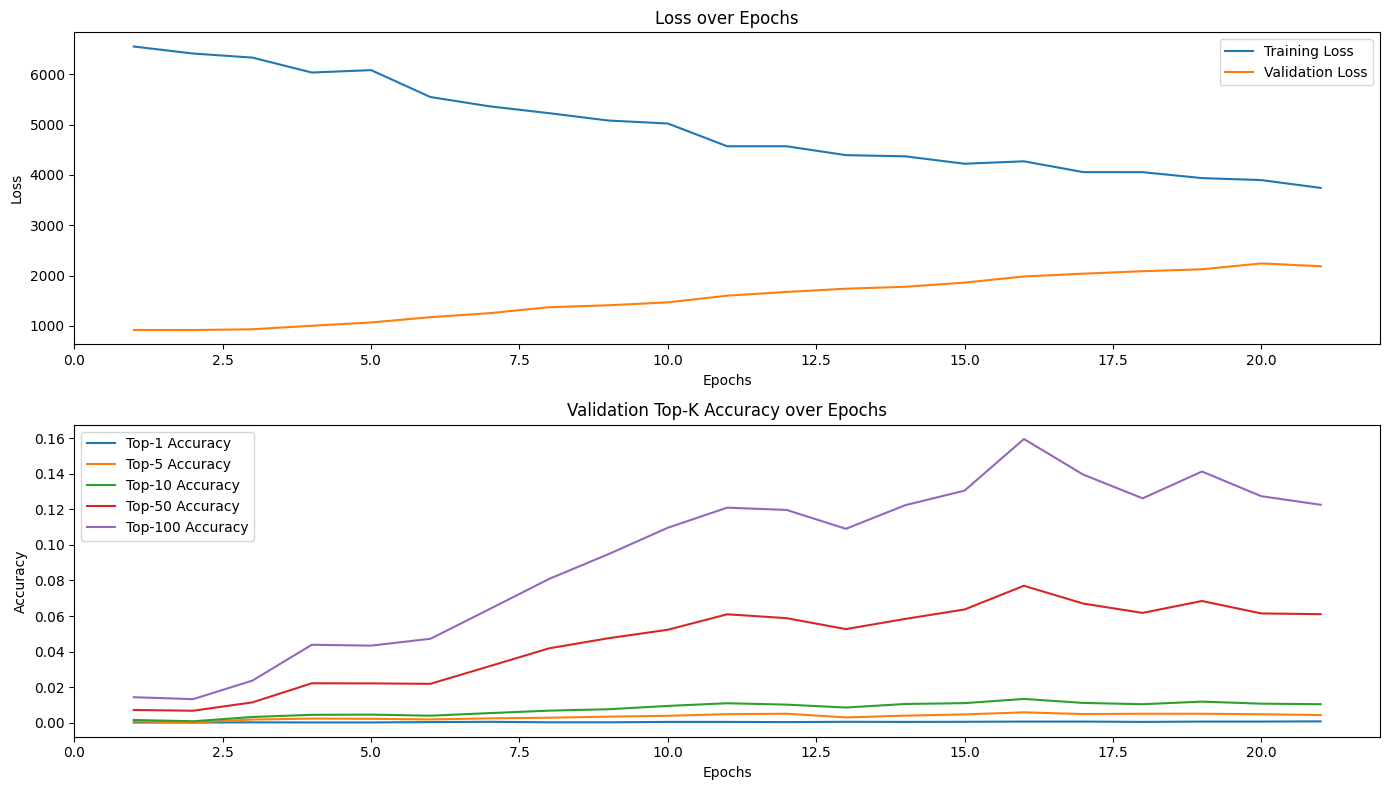

In [85]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
#plot_metrics(history)
plot_metrics(model_history.history)


In [ ]:
# ==================================================
# SAVE MODEL - Save the query and item models separately
# ==================================================
import os

# Create a directory for the models if it doesn't exist
model_dir = "event_recommender_model"
os.makedirs(model_dir, exist_ok=True)

# Save the query tower
query_model_path = os.path.join(model_dir, "query_tower")
model.query_model.save(query_model_path)
print(f"Query model saved to {query_model_path}")

# Save the item tower
item_model_path = os.path.join(model_dir, "item_tower")
model.item_model.save(item_model_path)
print(f"Item model saved to {item_model_path}")

# Save vocabularies and preprocessing info for later use
import pickle

# Save vocabulary lists and any preprocessing parameters
vocab_data = {
    "user_id_list": user_id_list,
    "event_id_list": event_id_list,
    "user_city_list": user_city_list,
    "event_city_list": event_city_list,
    "event_type_list": event_type_list,
    "user_interest_list": user_interest_list,
    "title_list": title_list,
    "embed_dim": EMBED_DIM
}

with open(os.path.join(model_dir, "vocab_data.pkl"), "wb") as f:
    pickle.dump(vocab_data, f)
print(f"Vocabulary data saved to {os.path.join(model_dir, 'vocab_data.pkl')}")


In [ ]:
#==================================================
# LOAD MODEL - Function to load the saved model
# ==================================================
def load_recommender_model(model_dir="event_recommender_model"):
    """
    Load the saved two-tower recommendation model
    
    Args:
        model_dir: Directory where model components are saved
        
    Returns:
        query_model: Loaded query tower model
        item_model: Loaded item tower model
        vocab_data: Dictionary with vocabulary data
    """
    # Load vocabulary data
    with open(os.path.join(model_dir, "vocab_data.pkl"), "rb") as f:
        vocab_data = pickle.load(f)
    
    # Load the query and item models
    query_model = tf.keras.models.load_model(
        os.path.join(model_dir, "query_tower")
    )
    
    item_model = tf.keras.models.load_model(
        os.path.join(model_dir, "item_tower")
    )
    
    print("Models loaded successfully!")
    return query_model, item_model, vocab_data

In [ ]:
# ==================================================
# INFERENCE EXAMPLE - Generate recommendations for a user
# ==================================================
def generate_recommendations(query_model, item_model, user_data, event_df, top_k=10):
    """
    Generate event recommendations for a user
    
    Args:
        query_model: The query tower model
        item_model: The item tower model
        user_data: Dictionary with user features
        event_df: DataFrame with event data
        top_k: Number of recommendations to return
        
    Returns:
        recommendations: DataFrame with top-k recommended events
    """
    # Convert user data to tensor format
    user_features = {k: tf.constant([v]) for k, v in user_data.items()}
    
    # Get user embedding
    user_embedding = query_model(user_features)
    
    # Prepare event features
    event_ds = df_to_ds(event_df[CANDIDATE_FEATURES]).batch(len(event_df))
    event_batch = next(iter(event_ds))
    
    # Get event embeddings
    event_embeddings = item_model(event_batch)
    
    # Calculate similarity scores
    similarity = tf.matmul(
        user_embedding, tf.transpose(event_embeddings)
    )
    
    # Get top-k recommendations
    _, indices = tf.math.top_k(similarity[0], k=top_k)
    recommended_event_indices = indices.numpy()
    
    # Return the recommended events
    recommendations = event_df.iloc[recommended_event_indices].copy()
    recommendations['score'] = similarity[0][recommended_event_indices].numpy()
    
    return recommendations

# Example of loading and using the model for inference
#if __name__ == "__main__":
# Load the saved models
query_model, item_model, vocab_data = load_recommender_model()

# Example user data (adjust with your actual feature names)
sample_user = {
    "user_id": "user_123",
    "age": 28,
    "user_city": "New York",
    "user_interests": "music concerts tech"
}

# Load your event dataset (assuming you saved it)
# You might need to load this from your database or saved file
import pandas as pd
# Example: event_df = pd.read_csv("events_data.csv")

# If you want to test with your existing data:
event_df = item_df  # Using the item_df created earlier

# Generate recommendations
if 'event_df' in locals():
    recommendations = generate_recommendations(
        query_model, item_model, sample_user, event_df, top_k=5
    )
    print("\nTop 5 recommended events:")
    print(recommendations[["event_id", "event_type", "event_city", "score"]])
else:
    print("Please load your event data to generate recommendations")

In [107]:
# Connect to Hopsworks Model Registry
mr = project.get_model_registry()

# Create a wrapper module for the query model
class QueryModelModule(tf.Module):
    def __init__(self, query_model):
        self.query_model = query_model

    @tf.function()
    def compute_emb(self, instances):
        query_emb = self.query_model(instances)
        return {
            "user_id": instances["user_id"],
            "user_city": instances["user_city"],
            "age": instances["age"],
            "user_interests": instances["user_interests"],
            "query_emb": query_emb,
        }

# Wrap query_model
query_model_module = QueryModelModule(model.query_model)


In [108]:

# Define input specifications
instances_spec = {
    'user_id': tf.TensorSpec(shape=(None,), dtype=tf.string),
    'user_city': tf.TensorSpec(shape=(None,), dtype=tf.string),
    'age': tf.TensorSpec(shape=(None,), dtype=tf.int64),
    'user_interests': tf.TensorSpec(shape=(None,), dtype=tf.string),
}

# Get the concrete function
signatures = query_model_module.compute_emb.get_concrete_function(instances_spec)

# Save models to disk
tf.saved_model.save(
    query_model_module,
    "query_model",
    signatures=signatures,
)

tf.saved_model.save(
    model.item_model,
    "candidate_model"
)


2025-04-02 23:22:28,105 INFO: Function `compute_emb` contains input name(s) instances, table_handle, 1943261, 1943271, resource with unsupported characters which will be renamed to instances_3, query_tower_42_sequential_195_string_lookup_268_none_lookup_lookuptablefindv2_table_handle, query_tower_42_embedding_164_embedding_lookup_1943261, query_tower_42_sequential_195_embedding_163_embedding_lookup_1943271, query_tower_42_sequential_196_dense_199_biasadd_readvariableop_resource in the SavedModel.
INFO:tensorflow:Assets written to: query_model/assets
2025-04-02 23:22:37,325 INFO: Assets written to: query_model/assets
INFO:tensorflow:Assets written to: candidate_model/assets
2025-04-02 23:22:40,597 INFO: Assets written to: candidate_model/assets


In [109]:

# Create schemas for Hopsworks
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Query model schema
query_df = train_df[["user_id", "user_city", "age", "user_interests"]]
query_model_input_schema = Schema(query_df)
query_model_output_schema = Schema([{
    "name": "query_embedding",
    "type": "float32",
    "shape": [EMBED_DIM],
}])

query_model_schema = ModelSchema(
    input_schema=query_model_input_schema,
    output_schema=query_model_output_schema,
)

# Sample for example
query_example = query_df.sample().to_dict("records")



In [110]:

# Create and save query model in registry
mr_query_model = mr.tensorflow.create_model(
    name="query_model",
    description="Model that generates query embeddings from user features for event recommendation",
    input_example=query_example,
    model_schema=query_model_schema,
)
mr_query_model.save("query_model")

# Candidate model schema
item_model_input_schema = Schema(item_df)
item_model_output_schema = Schema([{
    "name": "candidate_embedding",
    "type": "float32",
    "shape": [EMBED_DIM],
}])

candidate_model_schema = ModelSchema(
    input_schema=item_model_input_schema,
    output_schema=item_model_output_schema,
)




  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/58 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/635554 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/756 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3230722 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/97 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/494 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/query_model/1


In [111]:

# Sample for example
candidate_example = item_df.sample().to_dict("records")

# Create and save candidate model in registry
mr_candidate_model = mr.tensorflow.create_model(
    name="candidate_model",
    description="Model that generates candidate embeddings from event features",
    input_example=candidate_example,
    model_schema=candidate_model_schema,
)
mr_candidate_model.save("candidate_model")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/58 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/349583 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/425 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1989173 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/79 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/432 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1220788/models/candidate_model/1


Model(name: 'candidate_model', version: 1)

: 